<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Чтение-и-обработка-данных" data-toc-modified-id="Чтение-и-обработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Чтение и обработка данных</a></span></li><li><span><a href="#Графики:" data-toc-modified-id="Графики:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Графики:</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Подбор-гиперпараметров:" data-toc-modified-id="Подбор-гиперпараметров:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подбор гиперпараметров:</a></span></li></ul></div>

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack

import eli5
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, StratifiedKFold
from scipy.stats.mstats import gmean
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display_html

## Чтение и обработка данных

In [12]:
PATH_TO_DATA = 'data/'
SEED = 42

In [4]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
        
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sites = train_df[sites]
    test_sites = test_df[sites]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times, train_sites, test_sites

In [5]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times, train_sites, test_sites = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
)

Wall time: 27.6 s


In [6]:
print(X_train_sites.shape, X_test_sites.shape)

(253561, 50000) (82797, 50000)


In [13]:
time_split = TimeSeriesSplit(n_splits=10)
skf = StratifiedKFold(n_splits=15)

In [14]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [15]:
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, random_state=42, solver='liblinear')

In [16]:
cv_scores = cross_val_score(logit, X_train_sites, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
print('CV scores', cv_scores)
print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))

CV scores [0.67780788 0.86743393 0.89293301 0.79832125 0.85361628 0.93409222
 0.70641899 0.88966932 0.91145208 0.92592085]
CV mean: 0.8457665810618202, CV std: 0.08550021124547531


In [17]:
eli5.show_weights(estimator=logit, 
                  feature_names=vectorizer.get_feature_names(), top=30)

Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [18]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [58]:
def train_and_predict(model, X_train, y_train, X_test=None, X_val=None, y_val=pd.Series([None]), site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=-1)
    
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    if X_test != None:
        test_pred = model.predict_proba(X_test)[:, 1]
        write_to_submission_file(test_pred, submission_file_name) 
        
    if y_val.any():
        val_pred = model.predict_proba(X_val)[:, 1]
        print(roc_auc_score(y_val, val_pred))
    
    return cv_scores

## Графики:

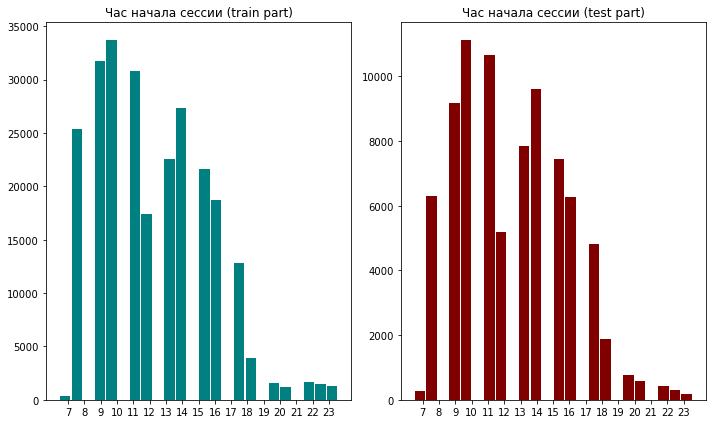

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_times['time1'].dt.hour, bins=24, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(test_times['time1'].dt.hour, bins=24, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[1].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[0].title.set_text('Час начала сессии (train part)')
ax[1].title.set_text('Час начала сессии (test part)')
plt.tight_layout()
plt.show()

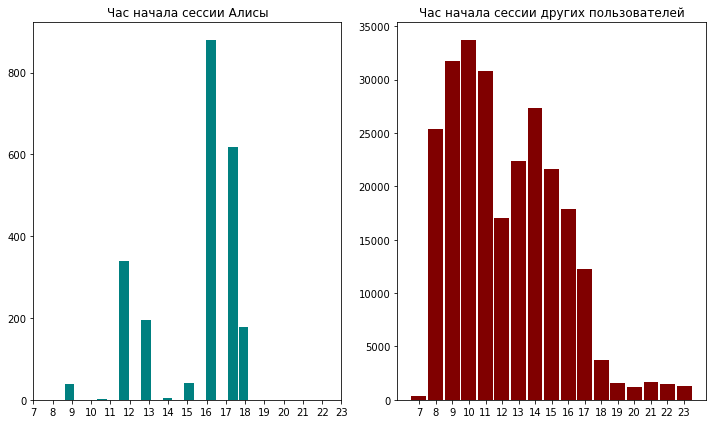

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_times['time1'].dt.hour[y_train==1], bins=17, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_times['time1'].dt.hour[y_train==0], bins=17, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[1].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[0].title.set_text('Час начала сессии Алисы')
ax[1].title.set_text('Час начала сессии других пользователей')
plt.tight_layout()
plt.show()

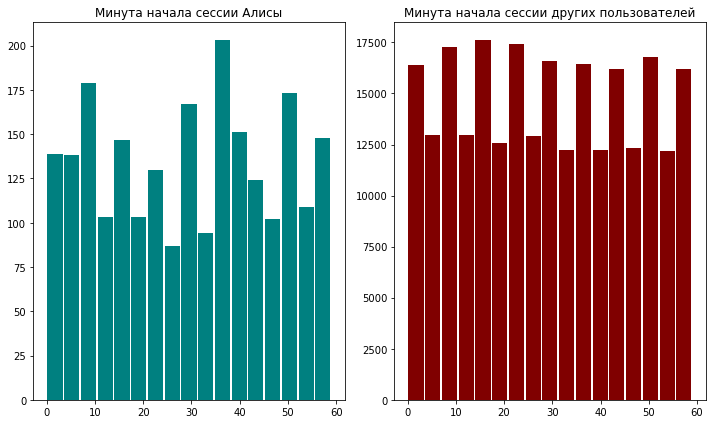

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_times['time1'].dt.minute[y_train==1], bins=17, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_times['time1'].dt.minute[y_train==0], bins=17, color='maroon', label='Users', rwidth=0.9)
ax[0].title.set_text('Минута начала сессии Алисы')
ax[1].title.set_text('Минута начала сессии других пользователей')
plt.tight_layout()
plt.show()

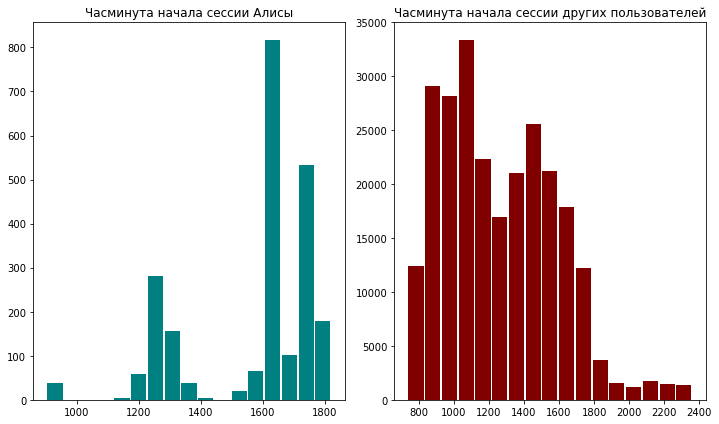

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_times['time1'].apply(lambda t: 100 * t.hour + t.minute)[y_train==1], bins=17, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_times['time1'].apply(lambda t: 100 * t.hour + t.minute)[y_train==0], bins=17, color='maroon', label='Users', rwidth=0.9)
train_times['time1']
ax[0].title.set_text('Часминута начала сессии Алисы')
ax[1].title.set_text('Часминута начала сессии других пользователей')
plt.tight_layout()
plt.show()

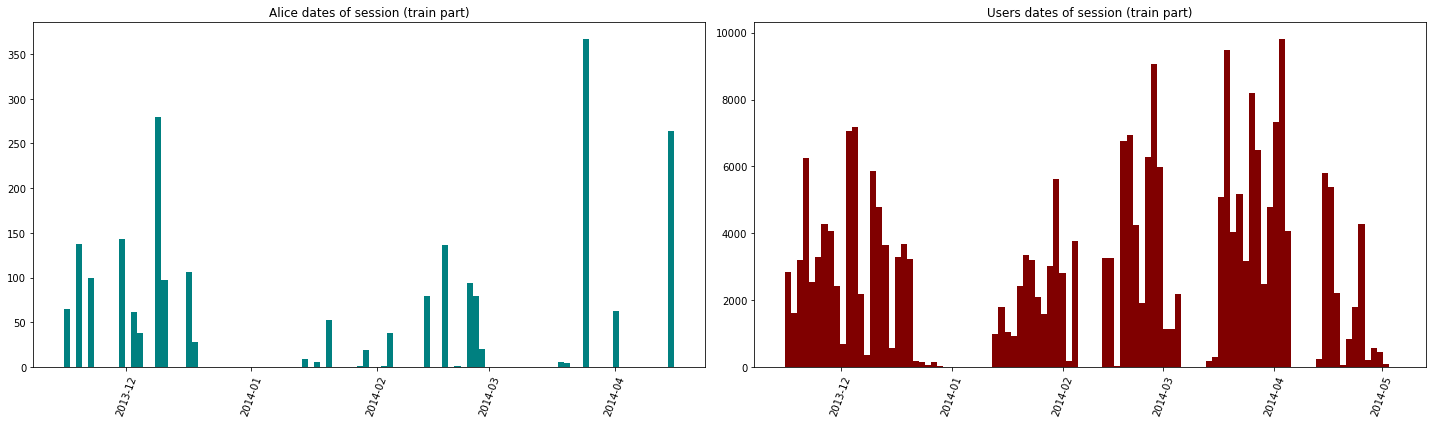

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].hist(train_times['time1'][y_train==1], bins=100, color='teal', label='Alice')
ax[1].hist(train_times['time1'][y_train==0], bins=100, color='maroon', label='Users')
ax[0].title.set_text('Alice dates of session (train part)')
ax[1].title.set_text('Users dates of session (train part)')
plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=70 )
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=70 )
plt.tight_layout()
plt.show()

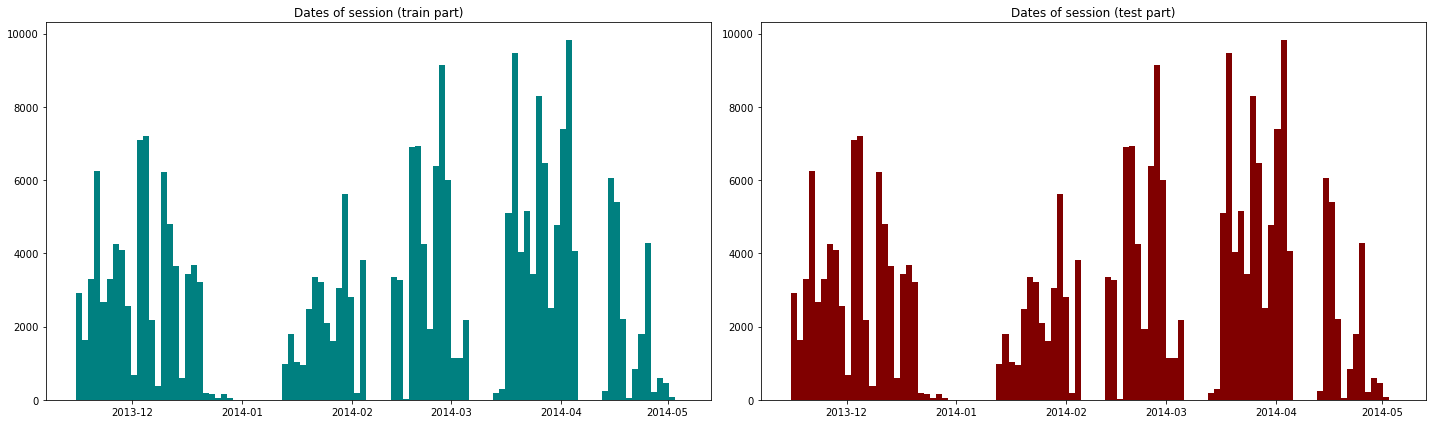

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].hist(train_times['time1'], bins=100, color='teal')
ax[1].hist(train_times['time1'], bins=100, color='maroon')
ax[0].title.set_text('Dates of session (train part)')
ax[1].title.set_text('Dates of session (test part)')
plt.tight_layout()
plt.show()

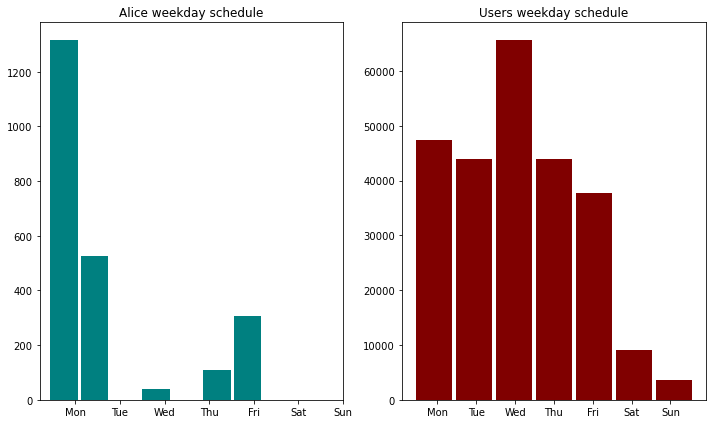

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_times['time1'].dt.dayofweek[y_train==1], bins=7, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_times['time1'].dt.dayofweek[y_train==0], bins=7, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('Alice weekday schedule')
ax[1].title.set_text('Users weekday schedule')
plt.tight_layout()
plt.show()

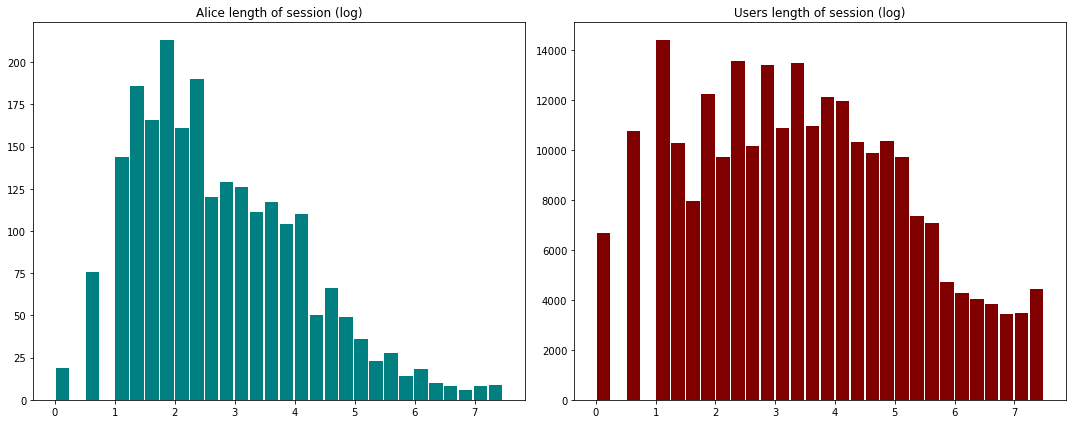

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].hist(np.log((train_times.max(axis=1) - train_times['time1']).dt.seconds[y_train==1] + 1), bins=30, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(np.log((train_times.max(axis=1) - train_times['time1']).dt.seconds[y_train==0] + 1), bins=30, color='maroon', label='Users', rwidth=0.9)
ax[0].title.set_text('Alice length of session (log)')
ax[1].title.set_text('Users length of session (log)')
plt.tight_layout()
plt.show()

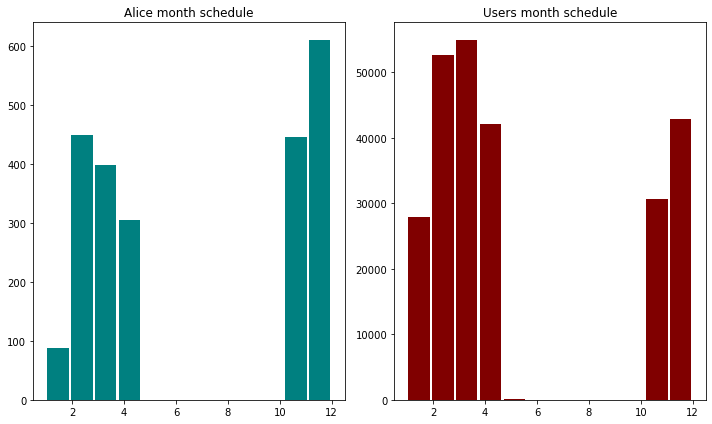

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_times['time1'].dt.month[y_train==1], bins=12, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_times['time1'].dt.month[y_train==0], bins=12, color='maroon', label='Users', rwidth=0.9)
ax[0].title.set_text('Alice month schedule')
ax[1].title.set_text('Users month schedule')
plt.tight_layout()
plt.show()

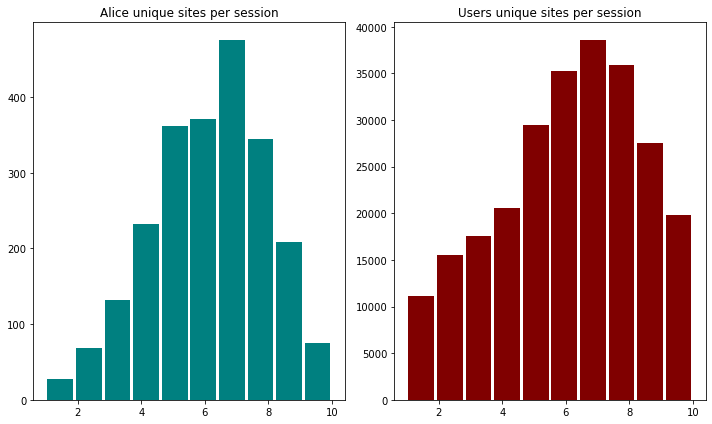

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_sites.apply(np.unique, axis=1).str.len()[y_train==1], color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_sites.apply(np.unique, axis=1).str.len()[y_train==0], color='maroon', label='Users', rwidth=0.9)
ax[0].title.set_text('Alice unique sites per session')
ax[1].title.set_text('Users unique sites per session')
plt.tight_layout()
plt.show()

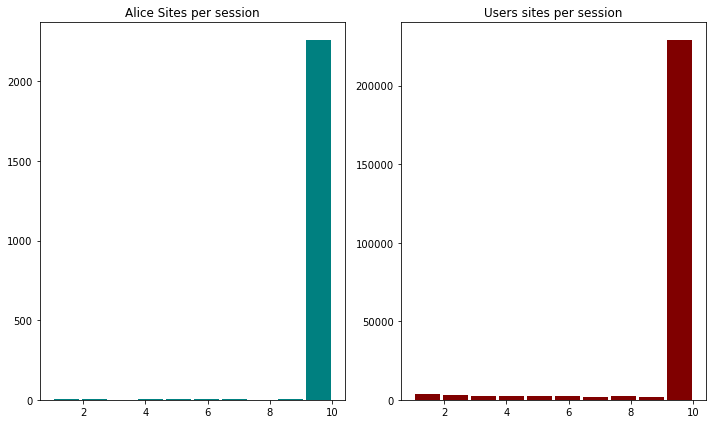

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_sites.notna().sum(axis=1)[y_train==1], color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_sites.notna().sum(axis=1)[y_train==0], color='maroon', label='Users', rwidth=0.9)
ax[0].title.set_text('Alice Sites per session')
ax[1].title.set_text('Users sites per session')
plt.tight_layout()
plt.show()

## Feature engineering

In [31]:
diffs = ['diff%s' % i for i in range(1, 10)]

X_features_train = pd.DataFrame()
hour = train_times['time1'].apply(lambda ts: ts.hour)
X_features_train['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
X_features_train['day'] = ((hour >= 12) & (hour <= 18)).astype('int')
X_features_train['evening'] = ((hour >= 19) & (hour <= 23)).astype('int')
#X_features_train['night'] = ((hour >= 0) & (hour <=6)).astype('int')
X_features_train['day_of_week'] = train_times['time1'].dt.day_name()
X_features_train['month'] = train_times['time1'].dt.month_name()
#X_features_train['year_month'] = train_times['time1'].apply(lambda t: 100 * t.year + t.month)
X_features_train['session_dur'] = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
X_features_train['is_weekend'] = train_times['time1'].apply(lambda x: 1 if x.date().weekday() in (5,6) else 0)
X_features_train['work_hours'] = train_times['time1'].apply(lambda ts: 1 if (ts.date().weekday() in (0,1,2,3)) & ((ts.hour>=9)&(ts.hour<=18)) else 0)
#X_features_train['month_day'] = train_times['time1'].apply(lambda t: 100 * t.month + t.day)
#X_features_train['num_of_sites'] = train_sites.notna().sum(axis=1).astype(str)
#X_features_train['uniq_sites'] = train_sites.apply(np.unique, axis=1).str.len()#.astype(str)
X_features_train['hour'] = hour.astype(str)
#X_features_train['hour_min'] = train_times['time1'].apply(lambda t: 100 * t.hour + t.minute)
X_features_train['lt10'] = train_sites.notna().sum(axis=1).lt(10).astype('int')
X_features_train[diffs] = train_times.diff(axis=1).fillna('0').astype('timedelta64[ms]').astype(int).drop(columns=['time1'])



X_features_test = pd.DataFrame()
hour = test_times['time1'].apply(lambda ts: ts.hour)
X_features_test['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
X_features_test['day'] = ((hour >= 12) & (hour <= 18)).astype('int')
X_features_test['evening'] = ((hour >= 19) & (hour <= 23)).astype('int')
#X_features_test['night'] = ((hour >= 0) & (hour <=6)).astype('int')
X_features_test['day_of_week'] = test_times['time1'].dt.day_name()
X_features_test['month'] = test_times['time1'].dt.month_name()
#X_features_test['year_month'] = test_times['time1'].apply(lambda t: 100 * t.year + t.month)
X_features_test['session_dur'] = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
X_features_test['is_weekend'] = test_times['time1'].apply(lambda x: 1 if x.date().weekday() in (5,6) else 0)
X_features_test['work_hours'] = test_times['time1'].apply(lambda ts: 1 if (ts.date().weekday() in (0,1,2,3)) & ((ts.hour>=8)&(ts.hour<=17)&(ts.hour!=12)) else 0)
#X_features_test['month_day'] = test_times['time1'].apply(lambda t: 100 * t.month + t.day)
#X_features_test['num_of_sites'] = test_sites.notna().sum(axis=1).astype(str)
#X_features_test['uniq_sites'] = test_sites.apply(np.unique, axis=1).str.len()#.astype(str)
X_features_test['hour'] = hour.astype(str)
#X_features_test['hour_min'] = test_times['time1'].apply(lambda t: 100 * t.hour + t.minute)
X_features_test['lt10'] = test_sites.notna().sum(axis=1).lt(10).astype('int')
X_features_test[diffs] = test_times.diff(axis=1).fillna('0').astype('timedelta64[ms]').astype(int).drop(columns=['time1'])


X_features_train

,morning,day,evening,day_of_week,month,session_dur,is_weekend,work_hours,hour,lt10,diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9
session_id,,,,,,,,,,,,,,,,,,,
27554,1,0,0,Friday,November,290000,0,0,7,0,0,1000,0,4000,1000,189000,0,0,95000
81350,1,0,0,Friday,November,804000,0,0,7,0,0,800000,0,0,1000,1000,2000,0,0
234665,1,0,0,Friday,November,11000,0,0,7,0,1000,1000,0,1000,0,3000,3000,0,2000
97610,1,0,0,Friday,November,538000,0,0,7,0,1000,8000,0,153000,0,46000,114000,208000,8000
161358,1,0,0,Friday,November,104000,0,0,7,1,1000,103000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129606,0,1,0,Saturday,May,0,1,0,18,1,0,0,0,0,0,0,0,0,0
53628,0,1,0,Saturday,May,0,1,0,18,1,0,0,0,0,0,0,0,0,0
84754,0,1,0,Saturday,May,0,1,0,18,1,0,0,0,0,0,0,0,0,0


In [32]:
month = pd.get_dummies(list(X_features_test['month']) + ['November','December'])
month = month[:-2].set_index(X_features_test.index)
X_features_test = pd.concat([X_features_test.drop(columns=['month']), month], axis=1) 

X_features_train = pd.get_dummies(X_features_train)
X_features_test = pd.get_dummies(X_features_test)

In [33]:
X_features_train.shape, X_features_test.shape

((253561, 47), (82797, 47))

In [34]:
scaler = StandardScaler()
to_scale =  diffs + ['session_dur']  #['year_month', 'session_dur', 'month_day']
X_features_train[to_scale] = scaler.fit_transform(X_features_train[to_scale])
X_features_test[to_scale] = scaler.transform(X_features_test[to_scale])
X_features_train

,morning,day,evening,session_dur,is_weekend,work_hours,lt10,diff1,diff2,diff3,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_7,hour_8,hour_9
session_id,,,,,,,,,,,,,,,,,,,,,
27554,1,0,0,0.512222,0,0,0,-0.191229,-0.170968,-0.186631,...,0,0,0,0,0,0,0,1,0,0
81350,1,0,0,2.249993,0,0,0,-0.191229,7.392189,-0.186631,...,0,0,0,0,0,0,0,1,0,0
234665,1,0,0,-0.431043,0,0,0,-0.181131,-0.170968,-0.186631,...,0,0,0,0,0,0,0,1,0,0
97610,1,0,0,1.350680,0,0,0,-0.181131,-0.104707,-0.186631,...,0,0,0,0,0,0,0,1,0,0
161358,1,0,0,-0.116621,0,0,1,-0.181131,0.794542,-0.186631,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129606,0,1,0,-0.468233,1,0,1,-0.191229,-0.180434,-0.186631,...,0,1,0,0,0,0,0,0,0,0
53628,0,1,0,-0.468233,1,0,1,-0.191229,-0.180434,-0.186631,...,0,1,0,0,0,0,0,0,0,0
84754,0,1,0,-0.468233,1,0,1,-0.191229,-0.180434,-0.186631,...,0,1,0,0,0,0,0,0,0,0


In [35]:
X_features_train.corr()

,morning,day,evening,session_dur,is_weekend,work_hours,lt10,diff1,diff2,diff3,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_7,hour_8,hour_9
morning,1.000000,-0.944392,-0.165127,-0.018984,0.027566,-0.157908,-0.055353,-0.014600,-0.017748,-0.007796,...,-0.222181,-0.120255,-0.075232,-0.066365,-0.079185,-0.073416,-0.070123,0.038130,0.346451,0.393053
day,-0.944392,1.000000,-0.168365,-0.004295,-0.085831,0.244752,0.026244,0.000462,0.001717,-0.004544,...,0.235263,0.127336,-0.076707,-0.067666,-0.080738,-0.074856,-0.071498,-0.036010,-0.327186,-0.371196
evening,-0.165127,-0.168365,1.000000,0.069792,0.174807,-0.260746,0.087217,0.042381,0.048052,0.036999,...,-0.039610,-0.021439,0.455600,0.401903,0.479544,0.444607,0.424660,-0.006296,-0.057208,-0.064903
session_dur,-0.018984,-0.004295,0.069792,1.000000,0.049329,-0.036618,0.204947,0.430103,0.458782,0.439455,...,-0.002650,0.010125,0.032698,0.041538,0.028117,0.033285,0.019573,0.012178,0.020898,-0.016696
is_weekend,0.027566,-0.085831,0.174807,0.049329,1.000000,-0.349684,0.038527,0.027934,0.030624,0.022325,...,0.007481,0.050753,0.070511,0.067228,0.093689,0.082388,0.070884,0.010762,0.034183,-0.003057
work_hours,-0.157908,0.244752,-0.260746,-0.036618,-0.349684,1.000000,-0.023424,-0.018992,-0.019202,-0.017836,...,0.055593,0.008783,-0.118796,-0.104795,-0.125039,-0.115929,-0.110728,-0.055768,-0.506712,0.116267
lt10,-0.055353,0.026244,0.087217,0.204947,0.038527,-0.023424,1.000000,0.171090,0.172017,0.137070,...,0.024108,0.032118,0.039316,0.043737,0.032177,0.036890,0.042117,0.014654,-0.018856,-0.011678
diff1,-0.014600,0.000462,0.042381,0.430103,0.027934,-0.018992,0.171090,1.000000,0.080132,0.059783,...,0.001995,0.010012,0.014250,0.027491,0.014323,0.022292,0.016675,0.002183,0.005080,-0.008699
diff2,-0.017748,0.001717,0.048052,0.458782,0.030624,-0.019202,0.172017,0.080132,1.000000,0.069062,...,0.000452,0.005573,0.025553,0.025689,0.017716,0.022345,0.015424,0.005364,-0.000467,-0.009125
diff3,-0.007796,-0.004544,0.036999,0.439455,0.022325,-0.017836,0.137070,0.059783,0.069062,1.000000,...,-0.004661,0.005484,0.016777,0.023304,0.016875,0.016904,0.008312,0.006047,0.008273,-0.005239


<AxesSubplot:>

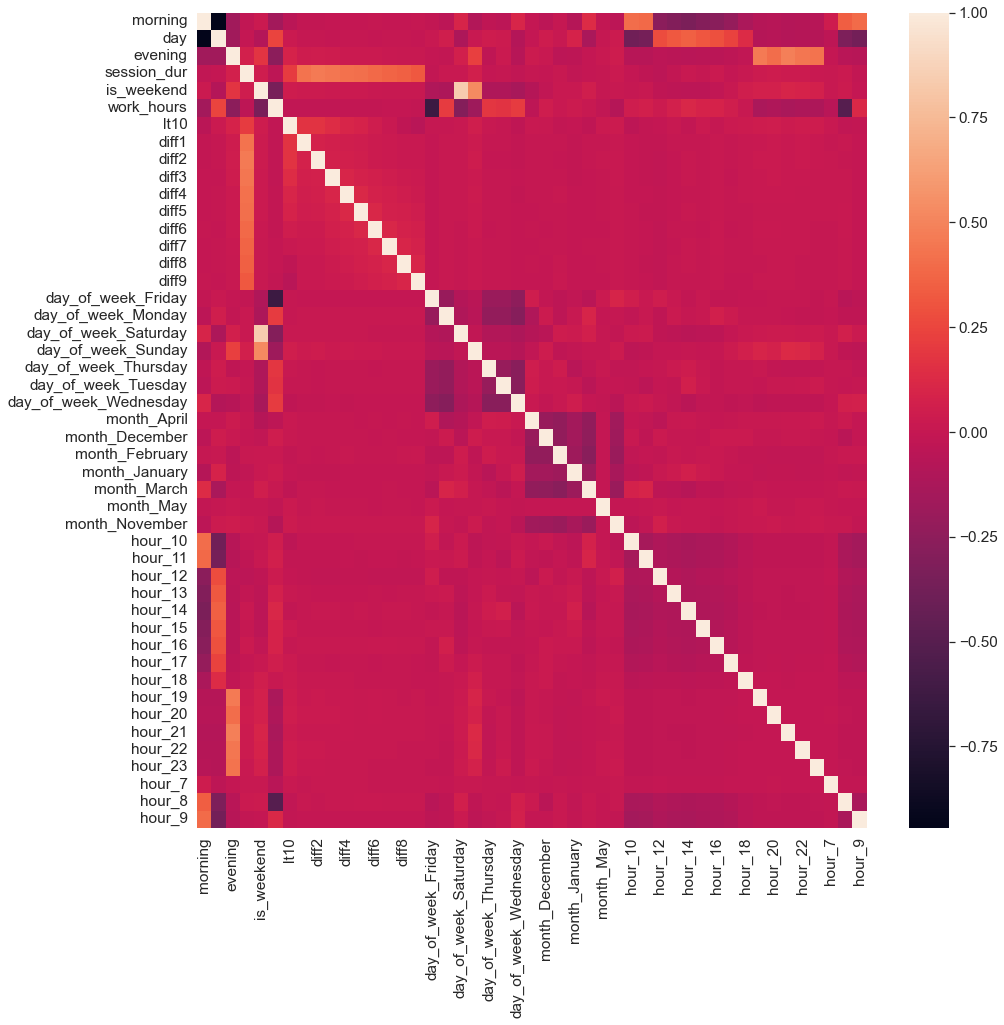

In [36]:
sns.set(font_scale=1.4)
plt.figure(figsize=(15,15))
sns.heatmap(X_features_train.corr(),cbar=True)

In [59]:
cv_scores0 = train_and_predict(model=logit, X_train=X_train_sites, y_train=y_train,
                               site_feature_names=vectorizer.get_feature_names(),
                               top_n_features_to_show=40,
                               cv=time_split)

CV scores [0.67780788 0.86743393 0.89293301 0.79832125 0.85361628 0.93409222
 0.70641899 0.88966932 0.91145208 0.92592085]
CV mean: 0.8457665810618202, CV std: 0.08550021124547531


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [40]:
X_train_final = X_train_sites.copy()
X_test_final = X_test_sites.copy()

#X_features_train.drop(columns=['day_of_week_Saturday', 'day_of_week_Sunday'], inplace=True) 
#X_features_test.drop(columns=['day_of_week_Saturday', 'day_of_week_Sunday'], inplace=True) 

for column in X_features_train.columns:
  X_train_final = hstack([X_train_final, X_features_train[column].values.reshape(-1, 1)])
for column in X_features_test.columns:
  X_test_final = hstack([X_test_final, X_features_test[column].values.reshape(-1, 1)])



X_train_final.shape, X_test_final.shape

((253561, 50047), (82797, 50047))

In [41]:
X_train, X_val, y_train_split, y_val = train_test_split(
X_train_final, y_train, test_size=0.1, random_state=17, stratify=y_train)

X_train.shape, X_val.shape

((228204, 50047), (25357, 50047))

## Testing

In [60]:
cv_scores1 = train_and_predict(model=logit, X_train=X_train, y_train=y_train_split, 
                               X_val=X_val, y_val=y_val,
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=list(X_features_train.columns),
                               cv=time_split, submission_file_name='submission.csv')

CV scores [0.96048251 0.96230052 0.97647003 0.97254834 0.97072794 0.97709815
 0.98269537 0.98983718 0.97404866 0.984819  ]
CV mean: 0.9751027706545736, CV std: 0.00882854218211108


Weight?,Feature
+5.265,vk.com
+5.169,www.melty.fr
+4.566,youwatch.org
+4.251,www.audienceinsights.net
+4.218,www.express.co.uk
+4.111,www.info-jeunes.net
+4.086,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.803,www.demotivateur.fr
+3.682,i1.ytimg.com
+3.487,www.banque-chalus.fr


New feature weights:
                  feature      coef
0                 morning -3.073775
1                     day  0.197435
2                 evening -2.229591
3             session_dur -0.150349
4              is_weekend -2.240291
5              work_hours  0.204962
6                    lt10 -1.185284
7                   diff1 -0.094941
8                   diff2  0.004524
9                   diff3 -0.004692
10                  diff4 -0.039426
11                  diff5  0.049118
12                  diff6 -0.056888
13                  diff7 -0.041044
14                  diff8 -0.199683
15                  diff9 -0.221359
16     day_of_week_Friday -0.238424
17     day_of_week_Monday  1.008967
18   day_of_week_Saturday -0.855770
19     day_of_week_Sunday -1.384522
20   day_of_week_Thursday -1.289263
21    day_of_week_Tuesday  0.347188
22  day_of_week_Wednesday -2.694107
23            month_April -0.690374
24         month_December -0.370253
25         month_February -0.661390
26     

## Подбор гиперпараметров:

In [62]:
c_values =  [1,2,3,4,5]#np.linspace(1, 20, 30)
logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [63]:
%%time
logit_grid_searcher.fit(X_train_final, y_train); 

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Wall time: 1min 26s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LogisticRegression(C=1, random_state=42,
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [1, 2, 3, 4, 5]}, scoring='roc_auc',
             verbose=1)

In [64]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9325202269292733, {'C': 5})

In [65]:
final_model = logit_grid_searcher.best_estimator_
#final_model = LogisticRegression(C=4, random_state=SEED, solver='liblinear')

In [67]:
cv_scores2 = train_and_predict(model=final_model, X_train=X_train, y_train=y_train_split, 
                               X_test=X_test_final, X_val=X_val, y_val=y_val,
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=list(X_features_train.columns),
                               cv=time_split, submission_file_name='submission1.csv')

CV scores [0.96802006 0.9722285  0.98366438 0.98671921 0.97649494 0.98650838
 0.98834458 0.99230828 0.98229393 0.98927805]
CV mean: 0.9825860299474547, CV std: 0.007501530402897737


Weight?,Feature
+12.406,www.express.co.uk
+10.500,cid-ed6c3e6a5c6608a4.users.storage.live.com
+8.739,tru.am
+6.721,www.melty.fr
+6.489,www.banque-chalus.fr
+6.385,vk.com
+6.340,api.bing.com
+5.885,browser-update.org
+5.876,s.radio-canada.ca
+5.846,www.clermont-filmfest.com


New feature weights:
                  feature      coef
0                 morning -3.584248
1                     day  0.286626
2                 evening -2.912020
3             session_dur -0.131160
4              is_weekend -2.900743
5              work_hours  0.453987
6                    lt10 -1.625351
7                   diff1 -0.113180
8                   diff2  0.009186
9                   diff3  0.024167
10                  diff4 -0.047061
11                  diff5  0.057537
12                  diff6 -0.052829
13                  diff7 -0.038270
14                  diff8 -0.173766
15                  diff9 -0.191757
16     day_of_week_Friday -0.199847
17     day_of_week_Monday  1.000559
18   day_of_week_Saturday -1.077567
19     day_of_week_Sunday -1.823176
20   day_of_week_Thursday -1.434634
21    day_of_week_Tuesday  0.240962
22  day_of_week_Wednesday -2.915939
23            month_April -0.813714
24         month_December -0.267542
25         month_February -0.696369
26     

In [68]:
cv_scores3 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final,
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=list(X_features_train.columns),
                               cv=skf, submission_file_name='submission_final.csv')


CV scores [0.92626027 0.92566242 0.87759584 0.77270306 0.99757775 0.99926607
 0.94453243 0.96655472 0.9733638  0.98385386 0.98352766 0.99456827
 0.96356319 0.99035274 0.99065517]
CV mean: 0.9526691492811107, CV std: 0.05830258199536502


Weight?,Feature
+12.559,www.express.co.uk
+11.930,cid-ed6c3e6a5c6608a4.users.storage.live.com
+8.805,tru.am
+6.529,www.banque-chalus.fr
+6.369,www.melty.fr
+6.365,api.bing.com
+6.207,vk.com
+6.091,browser-update.org
+5.978,mcetv.fr
+5.921,s.radio-canada.ca


New feature weights:
                  feature      coef
0                 morning -3.575098
1                     day  0.253481
2                 evening -2.965887
3             session_dur -0.138660
4              is_weekend -2.990161
5              work_hours  0.475285
6                    lt10 -1.702529
7                   diff1 -0.106479
8                   diff2  0.001846
9                   diff3  0.039674
10                  diff4 -0.061766
11                  diff5  0.044304
12                  diff6 -0.058387
13                  diff7 -0.016845
14                  diff8 -0.219457
15                  diff9 -0.181452
16     day_of_week_Friday -0.177005
17     day_of_week_Monday  1.019490
18   day_of_week_Saturday -1.124594
19     day_of_week_Sunday -1.865568
20   day_of_week_Thursday -1.471928
21    day_of_week_Tuesday  0.250952
22  day_of_week_Wednesday -2.918851
23            month_April -0.828296
24         month_December -0.278281
25         month_February -0.669946
26     